# Crosstalk ploting
1. time evolution of expectation of $ \sigma_z(t)$ 

Running QuTiP simulation (isolated system - Schrödinger equation)...
Simulation complete.


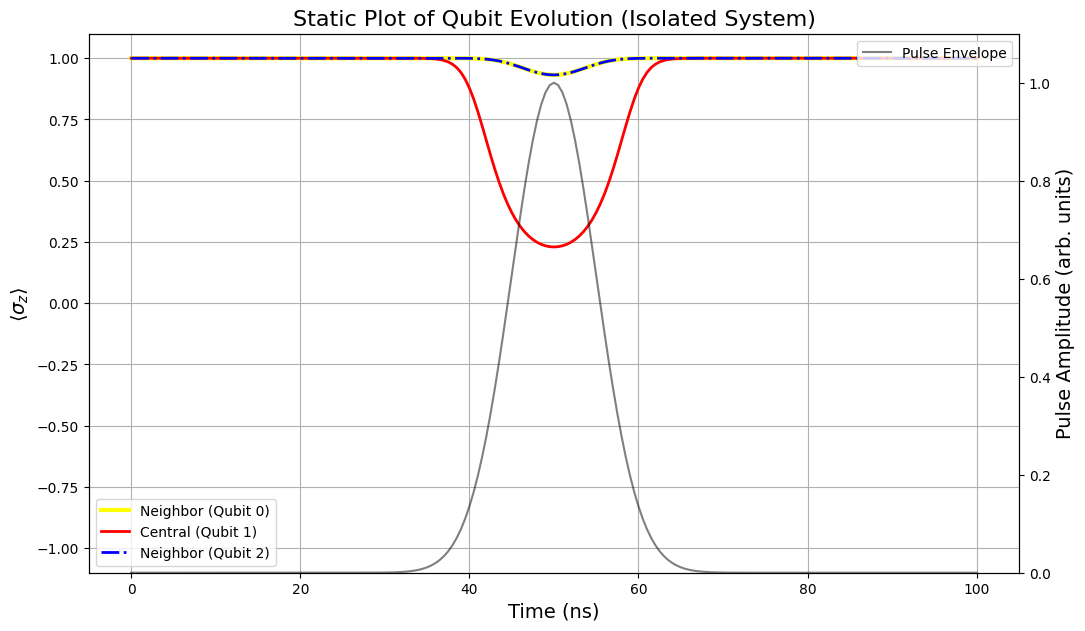

In [6]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- 1. SETUP THE SIMULATION (NANOSECOND SCALE) ---

# System parameters
N = 3
qubit_c = 1
w_q = 5.0 * 2 * np.pi        # Qubit frequency in rad/ns (i.e., 5 GHz)
Omega_c = 10.0 * 2 * np.pi   # Rabi frequency in rad/ns (i.e., 10 GHz)
J_coupling = 0.1 * Omega_c   # Induced coupling strength

# Pulse parameters (in nanoseconds)
t_total = 100.0
t0 = 50.0
tau = 5.0

def pulse_shape(t, args):
    """Gaussian pulse envelope."""
    return np.exp(-(t - args['t0'])**2 / (2 * args['tau']**2))

# Decoherence parameters (in nanoseconds) - THESE ARE NO LONGER USED FOR SESOLVE
# T1 = 50000.0  # 50 us
# T2_star = 10000.0  # 10 us
# gamma1 = 1.0 / T1
# gamma2_star = 1.0 / T2_star

# --- 2. CONSTRUCT HAMILTONIAN AND OPERATORS ---

# Pauli operators for each qubit
sx = [qt.tensor([qt.qeye(2)]*i + [qt.sigmax()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]
sz = [qt.tensor([qt.qeye(2)]*i + [qt.sigmaz()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]
# sm = [qt.tensor([qt.qeye(2)]*i + [qt.sigmam()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)] # Not needed for sesolve

# Drift Hamiltonian
H_drift = -0.5 * w_q * sz[0] - 0.5 * w_q * sz[1] - 0.5 * w_q * sz[2]

# Control and Crosstalk Hamiltonian operators
H_control_op = Omega_c * sx[qubit_c]
H_crosstalk_op = J_coupling * (sx[qubit_c-1] * sx[qubit_c] + sx[qubit_c] * sx[qubit_c+1])
H = [H_drift, [H_control_op + H_crosstalk_op, pulse_shape]]



psi0 = qt.tensor(qt.basis(2,0), qt.basis(2,0), qt.basis(2,0))
tlist = np.linspace(0, t_total, 201)
args = {'t0': t0, 'tau': tau}

print("Running QuTiP simulation (isolated system - Schrödinger equation)...")
# CHANGE mesolve TO sesolve AND REMOVE c_ops ARGUMENT
result = qt.sesolve(H, psi0, tlist, e_ops=[sz[0], sz[1], sz[2]], args=args)
print("Simulation complete.")

# --- 4. PLOTTING (remains largely the same) ---
exp_sz0 = result.expect[0]
exp_sz1 = result.expect[1]
exp_sz2 = result.expect[2]
times = tlist

# --- 1. COMPUTE PULSE VALUES FOR PLOTTING ---
pulse_vals = [pulse_shape(t, args) for t in times]

# --- 2. CREATE THE STATIC PLOT ---
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(times, exp_sz0, label='Neighbor (Qubit 0)', color='yellow', linestyle='-', linewidth=3)
ax1.plot(times, exp_sz1, label='Central (Qubit 1)', color='red', linestyle='-', linewidth=2)
ax1.plot(times, exp_sz2, label='Neighbor (Qubit 2)', color='blue', linestyle='-.', linewidth=2)

ax1.set_xlabel('Time (ns)', fontsize=14)
ax1.set_ylabel(r'$\langle \sigma_z \rangle$', fontsize=14)
ax1.set_title('Static Plot of Qubit Evolution (Isolated System)', fontsize=16)
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_ylim(-1.1, 1.1)

# --- 3. OVERLAY THE PULSE SHAPE ---
ax2 = ax1.twinx()
ax2.plot(times, pulse_vals, label='Pulse Envelope', color='black', alpha=0.5)
ax2.set_ylabel('Pulse Amplitude (arb. units)', fontsize=14)
ax2.legend(loc='upper right')
ax2.set_ylim(0, 1.1)

plt.show()


Running QuTiP simulation (isolated system with compensation)...
Simulation complete.


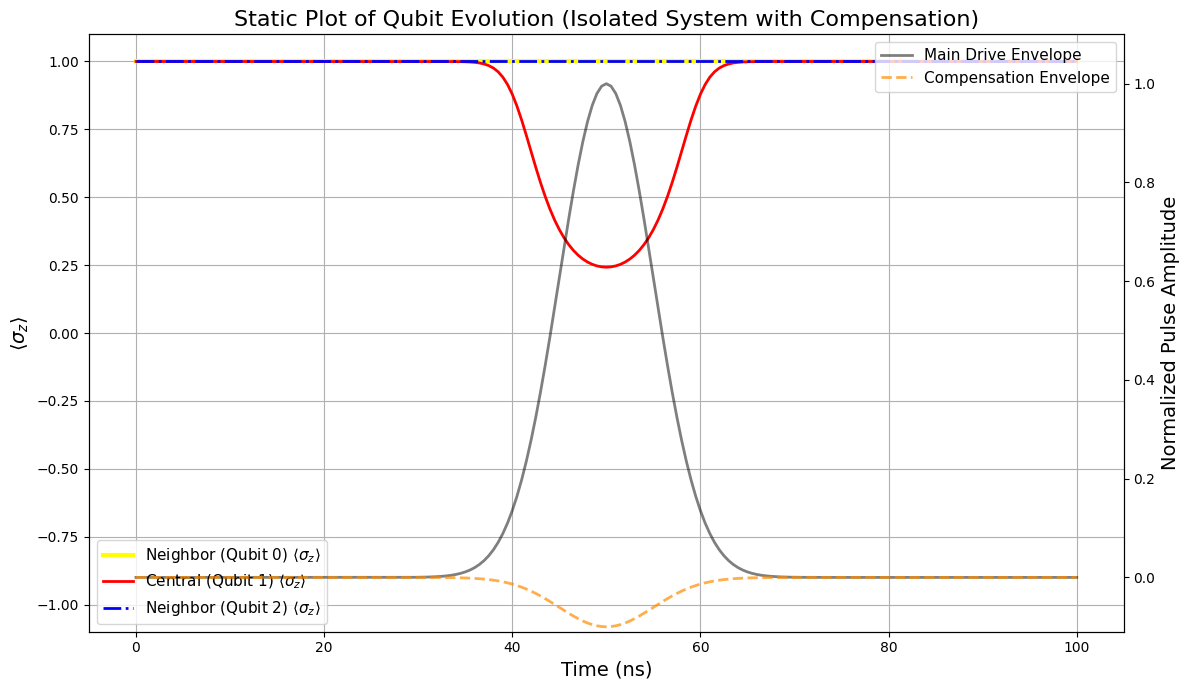

In [7]:
# compensatsion

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
# No need for FuncAnimation for a static plot

# --- 1. SETUP THE SIMULATION (NANOSECOND SCALE) ---

# System parameters
N = 3
qubit_c = 1 # Central qubit (Qubit 1)
w_q = 5.0 * 2 * np.pi        # Qubit frequency in rad/ns (i.e., 5 GHz)
Omega_c = 10.0 * 2 * np.pi   # Rabi frequency of the main drive in rad/ns (i.e., 10 GHz)
J_coupling = 0.1 * Omega_c   # Induced coupling strength (crosstalk)

# Compensation pulse amplitude.
# It's set to J_coupling and applied with an inverted phase to mitigate crosstalk.
# The amplitude is relative to the main drive's Omega_c.
Omega_comp = J_coupling

# Pulse parameters (in nanoseconds)
t_total = 100.0
t0 = 50.0
tau = 5.0

def pulse_shape(t, args):
    """Gaussian pulse envelope for the main drive and crosstalk."""
    return np.exp(-(t - args['t0'])**2 / (2 * args['tau']**2))

def comp_pulse_shape(t, args):
    """Gaussian pulse envelope for the compensation drive (same shape as main)."""
    return np.exp(-(t - args['t0'])**2 / (2 * args['tau']**2))

# Decoherence parameters (not used for isolated system simulation)
# T1 = 50000.0  # 50 us
# T2_star = 10000.0  # 10 us
# gamma1 = 1.0 / T1
# gamma2_star = 1.0 / T2_star

# --- 2. CONSTRUCT HAMILTONIAN AND OPERATORS ---

# Pauli operators for each qubit
sx = [qt.tensor([qt.qeye(2)]*i + [qt.sigmax()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]
sz = [qt.tensor([qt.qeye(2)]*i + [qt.sigmaz()] + [qt.qeye(2)]*(N-1-i)) for i in range(N)]
# sm operators are not needed for Schrödinger equation

# Drift Hamiltonian (free evolution of qubits)
H_drift = -0.5 * w_q * sz[0] - 0.5 * w_q * sz[1] - 0.5 * w_q * sz[2]

# Control Hamiltonian for the central qubit (Qubit 1)
H_control_op = Omega_c * sx[qubit_c]

# Crosstalk Hamiltonian (induced by the main drive on neighbors)
# This term is proportional to the main drive and affects neighbors
H_crosstalk_op = J_coupling * (sx[qubit_c-1] * sx[qubit_c] + sx[qubit_c] * sx[qubit_c+1])

# Compensation Hamiltonian (to mitigate crosstalk)
# This term is applied with an inverted sign and amplitude Omega_comp
# It acts on the same qubits as the crosstalk
H_compensation_op = -Omega_comp * (sx[qubit_c-1] * sx[qubit_c] + sx[qubit_c] * sx[qubit_c+1])

# Full Hamiltonian list for QuTiP
# H = H_drift + (H_control_op + H_crosstalk_op) * pulse_shape(t) + H_compensation_op * comp_pulse_shape(t)
H = [
    H_drift,
    [H_control_op + H_crosstalk_op, pulse_shape], # Main drive and induced crosstalk
    [H_compensation_op, comp_pulse_shape]         # Compensation pulse
]

# Collapse operators (empty for isolated system simulation)
c_ops = []

# --- 3. RUN THE SIMULATION ---

psi0 = qt.tensor(qt.basis(2,0), qt.basis(2,0), qt.basis(2,0)) # All qubits initialized in |0>
tlist = np.linspace(0, t_total, 201)
args = {'t0': t0, 'tau': tau}

print("Running QuTiP simulation (isolated system with compensation)...")
# Using qt.sesolve for Schrödinger equation (isolated system)
result = qt.sesolve(H, psi0, tlist, e_ops=[sz[0], sz[1], sz[2]], args=args)
print("Simulation complete.")

# Extract expectation values for plotting
exp_sz0 = result.expect[0]
exp_sz1 = result.expect[1]
exp_sz2 = result.expect[2]
times = tlist # Alias tlist for clarity in plotting

# --- 4. COMPUTE PULSE VALUES FOR PLOTTING ---
pulse_vals = [pulse_shape(t, args) for t in times]
# Calculate compensation pulse values, scaled by its relative amplitude to the main drive
# The compensation pulse is inverted and its amplitude is Omega_comp / Omega_c times the main pulse
comp_vals = [- (Omega_comp / Omega_c) * pulse_shape(t, args) for t in times]

# --- 5. CREATE THE STATIC PLOT ---

# Setup the figure and primary axis for qubit expectation values
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot the expectation values on the primary axis (ax1)
ax1.plot(times, exp_sz0, label='Neighbor (Qubit 0) $\\langle\\sigma_z\\rangle$', color='yellow', linestyle='-', linewidth=3)
ax1.plot(times, exp_sz1, label='Central (Qubit 1) $\\langle\\sigma_z\\rangle$', color='red', linestyle='-', linewidth=2)
ax1.plot(times, exp_sz2, label='Neighbor (Qubit 2) $\\langle\\sigma_z\\rangle$', color='blue', linestyle='-.', linewidth=2)

# Set labels, title, and grid for the primary axis
ax1.set_xlabel('Time (ns)', fontsize=14)
ax1.set_ylabel(r'$\langle \sigma_z \rangle$', fontsize=14)
ax1.set_title('Static Plot of Qubit Evolution (Isolated System with Compensation)', fontsize=16)
ax1.legend(loc='lower left', fontsize=11)
ax1.grid(True)
ax1.set_ylim(-1.1, 1.1)

# Create a secondary axis that shares the same x-axis for pulse envelopes
ax2 = ax1.twinx()

# Plot the pulse envelopes on the secondary axis (ax2)
ax2.plot(times, pulse_vals, label='Main Drive Envelope', color='black', alpha=0.5, lw=2)
ax2.plot(times, comp_vals, '--', label='Compensation Envelope', color='darkorange', alpha=0.7, lw=2)
ax2.set_ylabel('Normalized Pulse Amplitude', fontsize=14)
ax2.legend(loc='upper right', fontsize=11)
ax2.set_ylim(-1.1 * (Omega_comp / Omega_c), 1.1) # Adjust y-lim to accommodate compensation pulse range

# Display the final plot
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()
